## 2.3 Data Exploration Report

In this section, we will explore the data and present our findings:

* Statistics: basic descriptive statistics for each feature (mean, median, range, standard deviation, etc.).
* Visualizations: charts or graphs that help understand the data better. These might include histograms, scatter plots, box plots, etc.
* Initial findings: any interesting insights gained from the data, potential relationships between features, or patterns in the data.
* Potential hypotheses: based on our initial exploration, propose hypotheses about the data that could be tested or investigated further in the data mining process.

### 2.3.1 File access and save paths
Here we will import the helper functions and setup up the save paths for the data and figures that are generated

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

In [19]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = './data/saville_row_east_west/'
OUTPUT_TABLES_PATH = './output/tables/2.3/'
OUTPUT_FIGURES_PATH = './output/figures/2.3/'

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap
custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, 'east_df.pkl'))
west_df = pd.read_pickle(os.path.join(DATA_PATH, 'west_df.pkl'))


In [20]:
east_ped_counts_descriptive = east_df['value'].describe().round(1)
west_ped_counts_descriptive = west_df['value'].describe().round(1)
east_ped_counts_descriptive, west_ped_counts_descriptive

(count    79522.0
 mean        76.9
 std        102.3
 min          0.0
 25%          7.0
 50%         30.0
 75%        112.0
 max       1898.0
 Name: value, dtype: float64,
 count    79787.0
 mean        99.9
 std        136.3
 min          0.0
 25%          7.0
 50%         40.0
 75%        141.0
 max       2432.0
 Name: value, dtype: float64)

In [38]:
east_ped_counts_descriptive.to_csv(os.path.join(OUTPUT_TABLES_PATH, 'East sensor descriptive statistics for pedestrian count.csv'))
west_ped_counts_descriptive.to_csv(os.path.join(OUTPUT_TABLES_PATH, 'West sensor descriptive statistics for pedestrian count.csv'))

In [21]:
# sorts east_df by hour and minute of the day
east_df = east_df.sort_values('time')

# groups on year-month-day-hour and yields sum (total pedestrians per hour)
hour_of_the_day_sum_df = east_df.groupby('year-month-day-hour') \
                       .agg({'value':'sum', 
                             'hour':'first', 
                             'time':'first',
                             'year-month':'first', 
                             'month':'first',
                             'month-hour':'first'}) \
                       .sort_values('hour') \
                       .reset_index()

# groups and sums on month-hour and yield mean (average pedestrians per hour in each month)
hour_month_average_df = hour_of_the_day_sum_df.groupby('month-hour') \
                                 .agg({'value':'mean', 
                                       'hour':'first', 
                                       'month':'first'}) \
                                 .sort_values('hour') \
                                 .reset_index()

In [22]:
len(east_df), len(hour_of_the_day_sum_df), len(hour_month_average_df)

(79522, 10457, 288)

## 2.3.2 Overview of Flow Patterns

#### 2.3.2.1 Average flow per hour by month
The following graph shows the annual variation in average flow for each month at each hour of the day

C:\Users\carro\AppData\Local\Temp\ipykernel_10668\3023881528.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=np.arange(1, len_months+1))


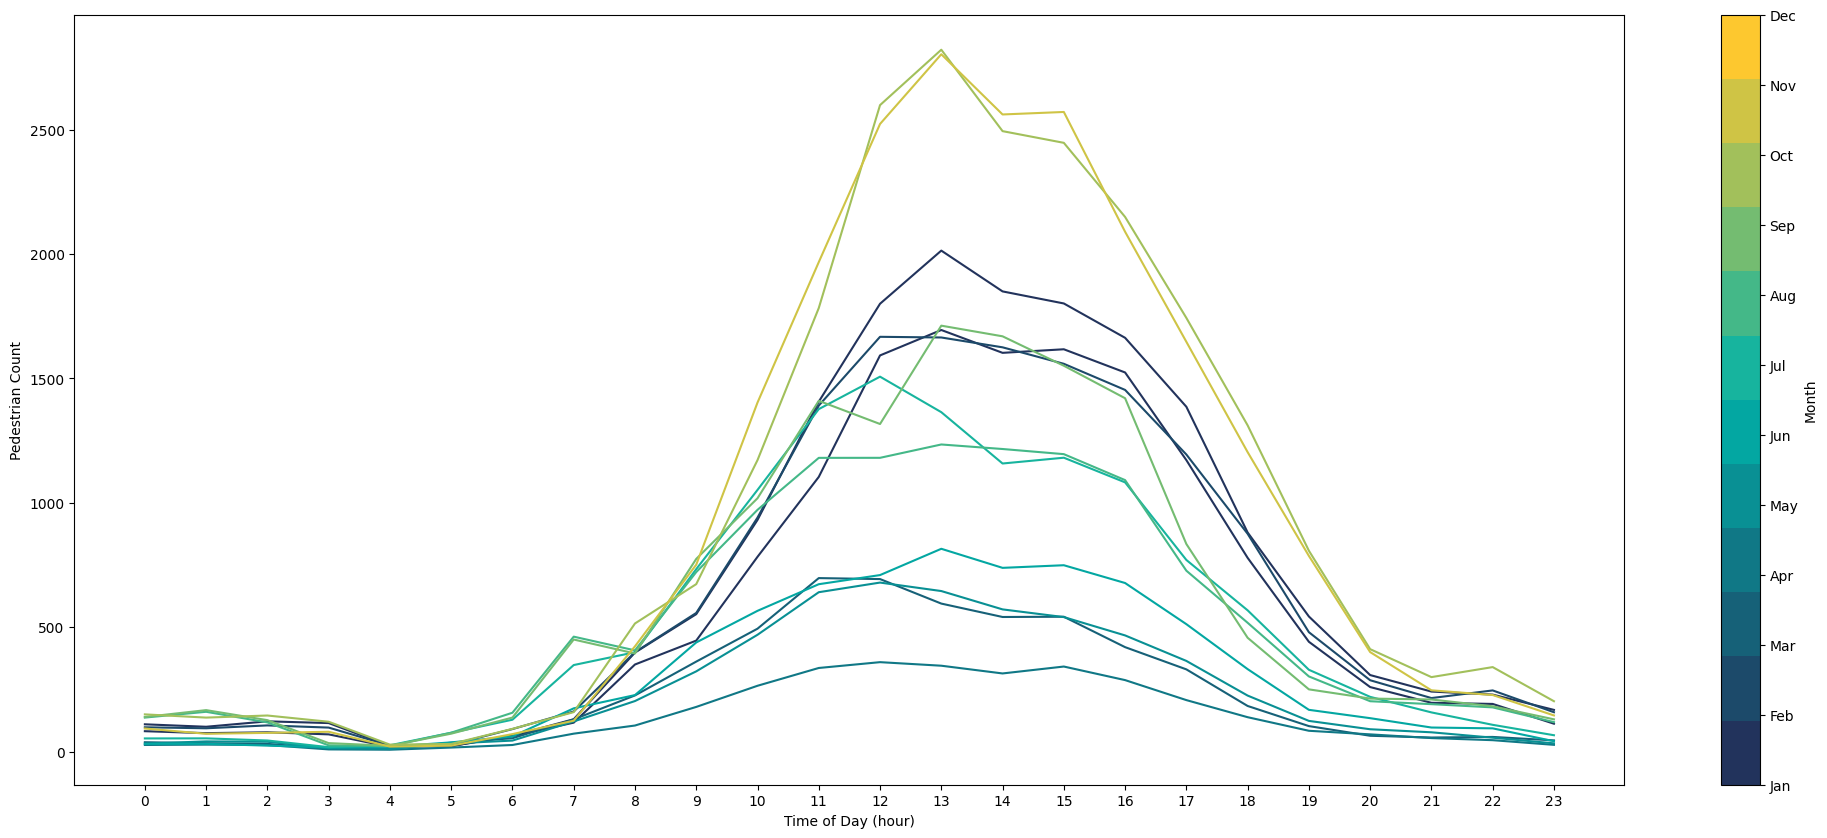

In [23]:
len_months = len(set(hour_month_average_df['month']))
cmap = matplotlib.colors.ListedColormap([custom_colormap(i/(len_months-1)) for i in range(len_months)])

fig, ax = plt.subplots(figsize=(25, 10))

# loop through each unique month value
for i, month in enumerate(set(hour_month_average_df['month'])):
    # filter the DataFrame for the current month
    month_df = hour_month_average_df[hour_month_average_df['month'] == month]
    
    # plot the line for the current month with the corresponding color from the colormap
    ax.plot(month_df['hour'].astype(str),
            month_df['value'],
            color=cmap(i - 1),
            label=f'Month {month}')

ax.set_xlabel('Time of day (hour)')
ax.set_ylabel('Pedestrian count')

# add a colorbar to show the mapping of colors to months
norm = matplotlib.colors.Normalize(vmin=1, vmax=len_months)
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=np.arange(1, len_months+1))
cbar.ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cbar.set_label('Month')

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH,'Average flow per hour by month.svg'), bbox_inches='tight')
plt.show()

#### 2.3.2.2 Flow per hour by month with average month trendline
The following graph shows the variation in flow throughout the day and across each month

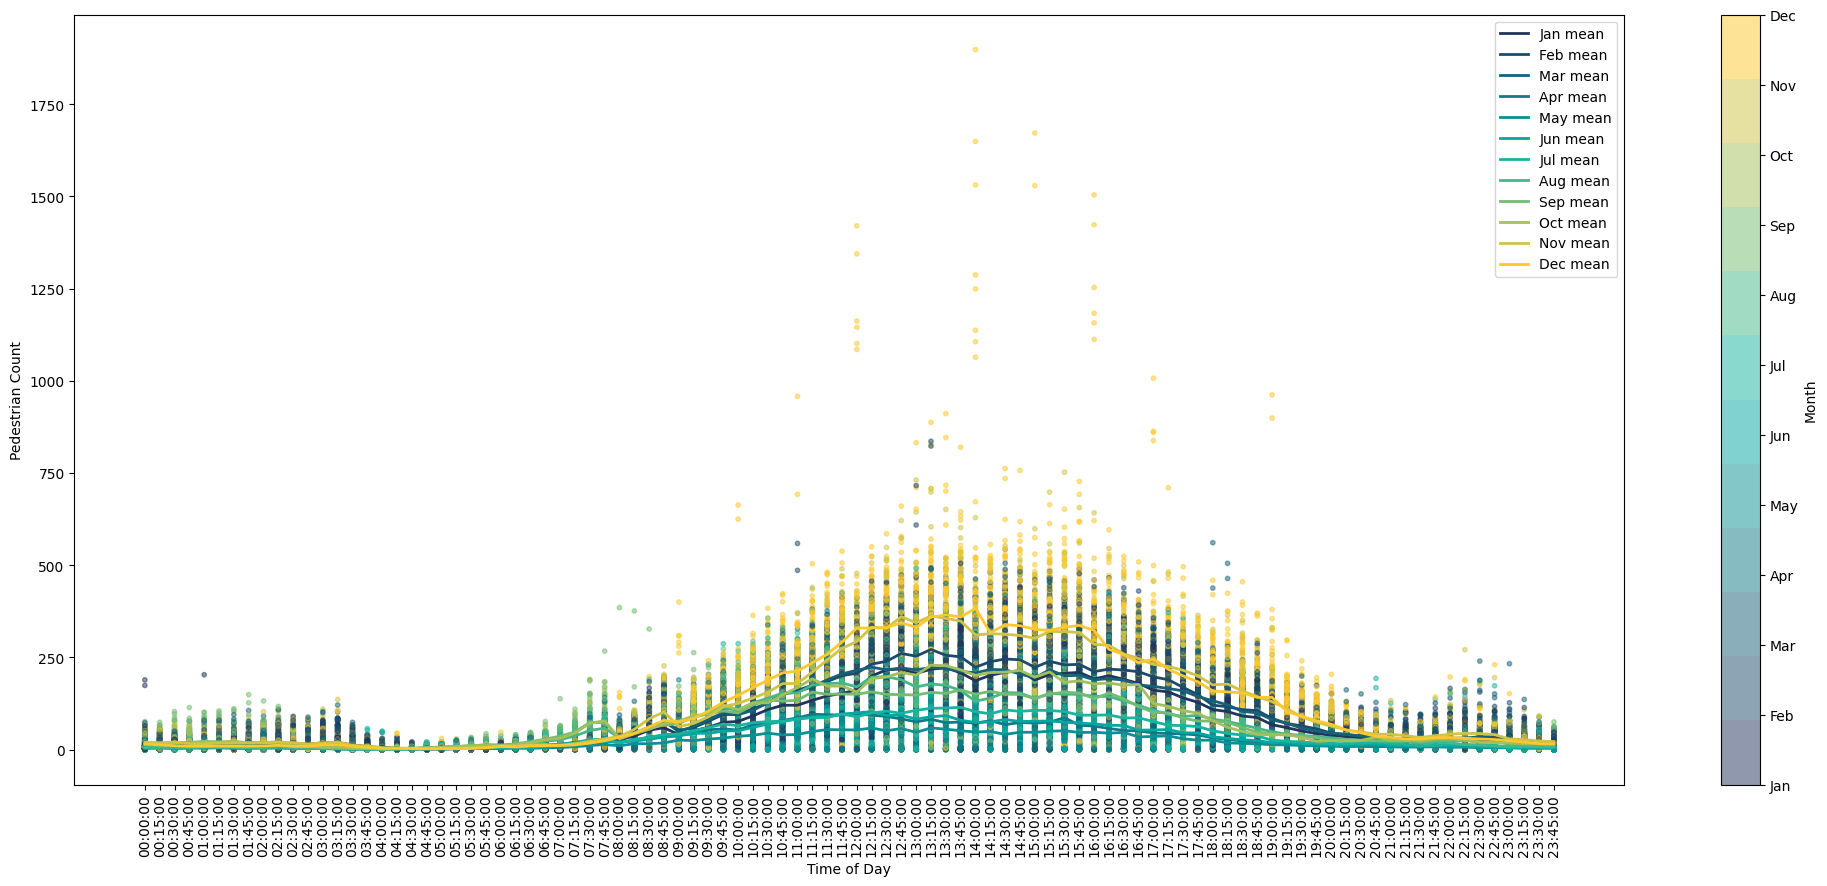

In [24]:
cmap = matplotlib.colors.ListedColormap([custom_colormap(i/11) for i in range(12)])

monthly_interval_mean_df = east_df.groupby(['month', 'time'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(25, 10))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month in range(1, 13):
    month_data = monthly_interval_mean_df[monthly_interval_mean_df['month'] == month]
    ax.plot(month_data['time'].astype(str), month_data['value'], linewidth=2, label=f'{month_names[month - 1]} mean', color=cmap.colors[month - 1])

ax.legend()

sc = ax.scatter(x=east_df['time'].astype(str), y=east_df['value'], c=east_df['month'], cmap=cmap, alpha=0.5, s=10)

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Pedestrian Count')

# add a colorbar to show the mapping of colors to months
cbar = plt.colorbar(sc, ticks=np.arange(1, 13))
cbar.ax.set_yticklabels(month_names)
cbar.set_label('Month')

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, 'Total Flow per 15 Min Period by Month.svg'))
plt.show()

#### 2.3.2.3 Flow per hour by month with average quarter trendline
The following graph shows the variation in flow throughout the day and across each quarter

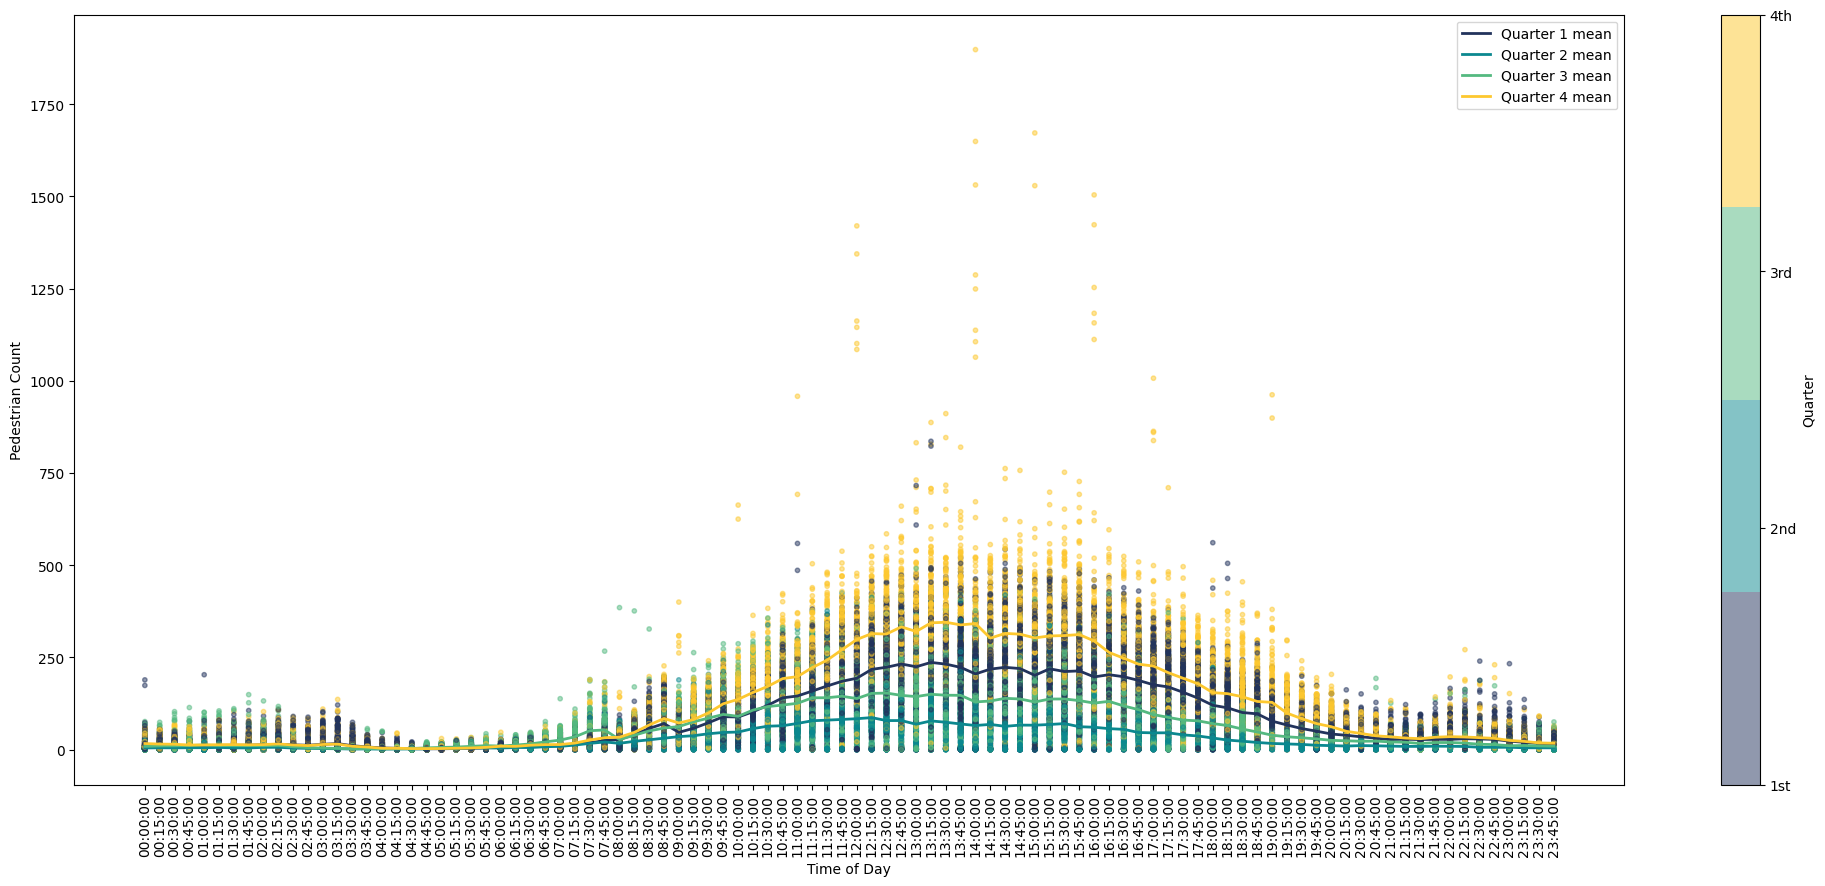

In [ ]:
cmap = matplotlib.colors.ListedColormap([custom_colormap(i/3) for i in range(4)])

quarter_interval_mean_df = east_df.groupby(['quarter', 'time'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(25, 10))
sc = ax.scatter(x=east_df['time'].astype(str), y=east_df['value'], c=east_df['quarter'], cmap=cmap, alpha=0.5, s=10)

for quarter in range(1, 5):
    quarter_data = quarter_interval_mean_df[quarter_interval_mean_df['quarter'] == quarter]
    ax.plot(quarter_data['time'].astype(str), quarter_data['value'], linewidth=2, label=f'Quarter {quarter} mean', color=cmap.colors[quarter - 1])

ax.legend()

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Pedestrian Count')

# add a colorbar to show the mapping of colors to quarters
cbar = plt.colorbar(sc, ticks=np.arange(1, 5))
cbar.ax.set_yticklabels(['1st','2nd','3rd','4th'])
cbar.set_label('Quarter')

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, 'Total Flow per 15 Min Period by Quarter.svg'))
plt.show()

#### 2.3.2.4 Flow per hour by month with average quarter trendline
The following graph shows the variation in flow throughout the day and across each quarter

In [27]:
# create a mask for weekdays (monday-friday)
weekday_mask = (east_df['dt'].dt.weekday < 5)

# create seperate dataframes for weekdays and weekends
weekday_east_df = east_df[weekday_mask]
weekend_east_df = east_df[-weekday_mask]

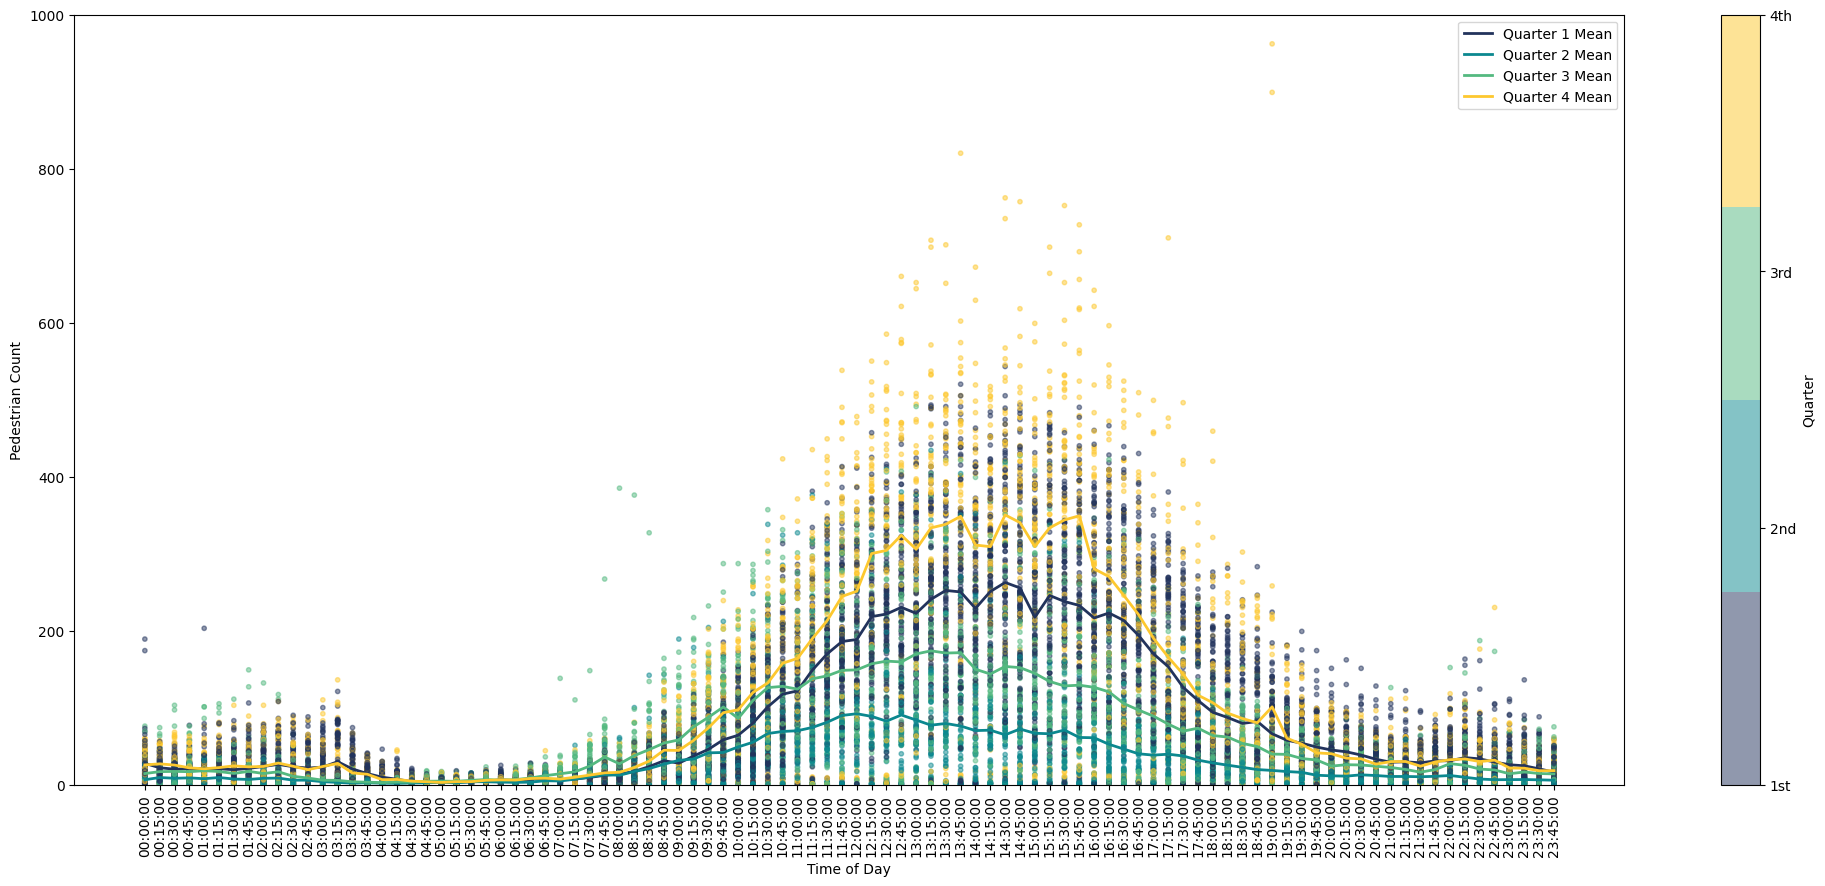

In [29]:
cmap = matplotlib.colors.ListedColormap([custom_colormap(i/3) for i in range(4)])

quarter_interval_mean_df = weekend_east_df.groupby(['quarter', 'time'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(25, 10))
sc = ax.scatter(x=weekend_east_df['time'].astype(str), y=weekend_east_df['value'], c=weekend_east_df['quarter'], cmap=cmap, alpha=0.5, s=10)

for quarter in range(1, 5):
    quarter_data = quarter_interval_mean_df[quarter_interval_mean_df['quarter'] == quarter]
    ax.plot(quarter_data['time'].astype(str), quarter_data['value'], linewidth=2, label=f'Quarter {quarter} Mean', color=cmap.colors[quarter - 1])

ax.legend()

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Pedestrian Count')
ax.set_ylim(0,1000)

# add a colorbar to show the mapping of colors to quarters
cbar = plt.colorbar(sc, ticks=np.arange(1, 5))
cbar.ax.set_yticklabels(['1st','2nd','3rd','4th'])
cbar.set_label('Quarter')

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, 'Weekend Total Flow per 15 Min Period by Quarter.svg'), bbox_inches='tight')
plt.show()

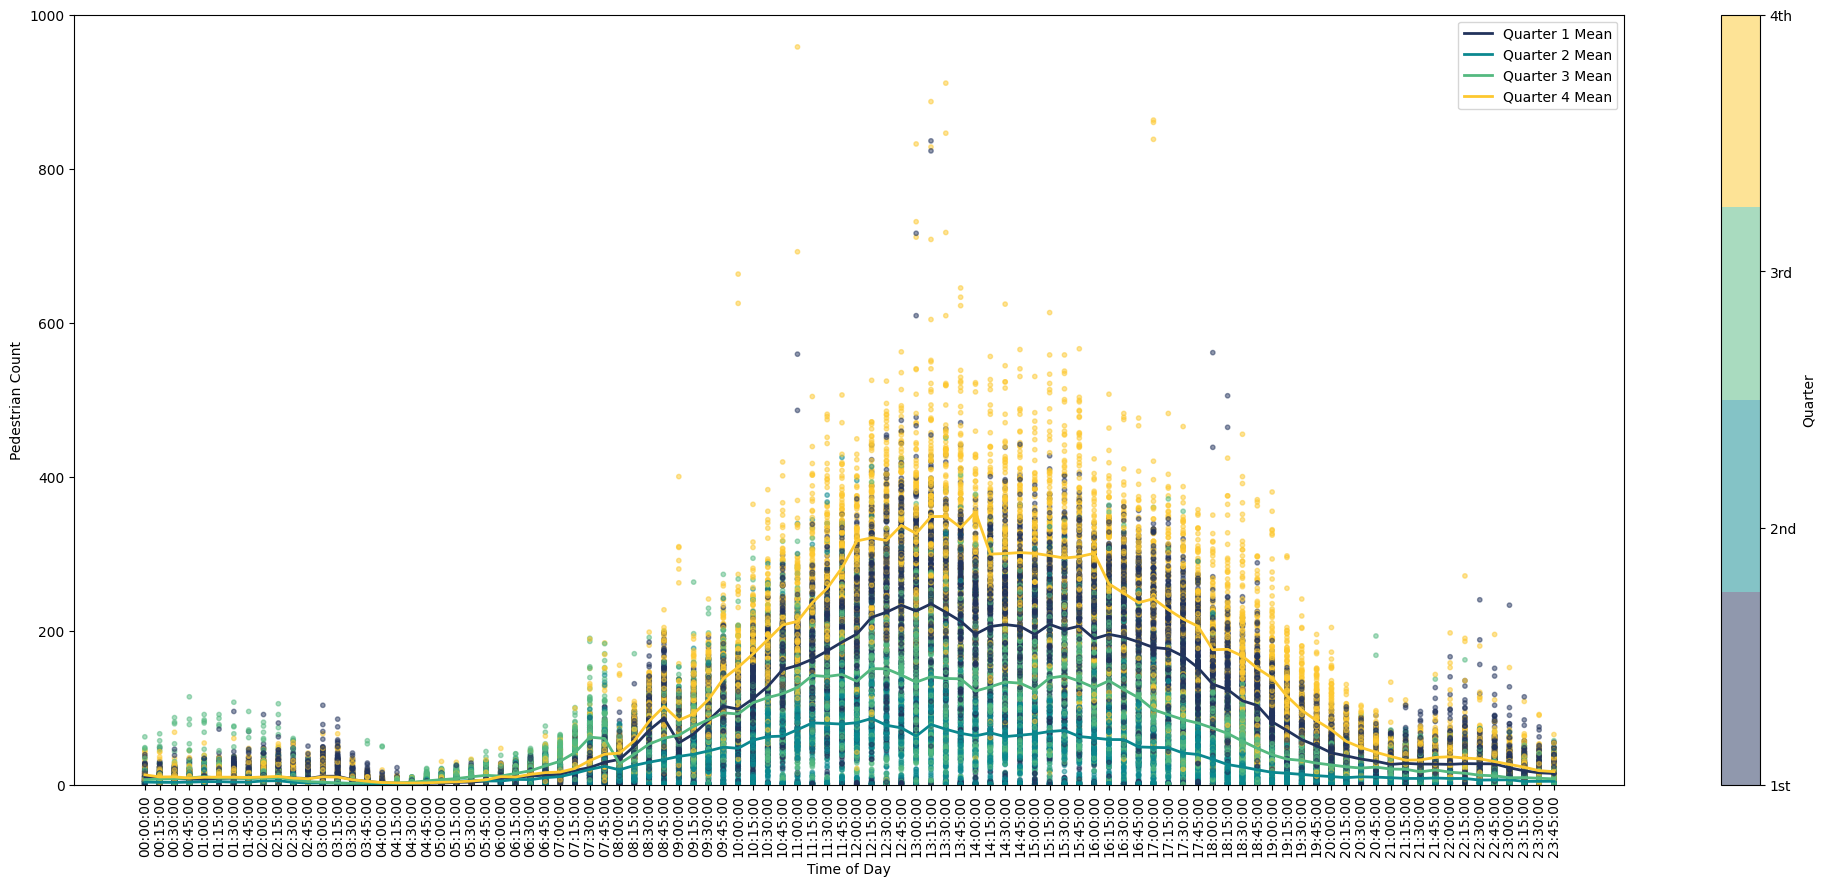

In [31]:
cmap = matplotlib.colors.ListedColormap([custom_colormap(i/3) for i in range(4)])

quarter_interval_mean_df = weekday_east_df.groupby(['quarter', 'time'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(25, 10))
sc = ax.scatter(x=weekday_east_df['time'].astype(str), y=weekday_east_df['value'], c=weekday_east_df['quarter'], cmap=cmap, alpha=0.5, s=10)

for quarter in range(1, 5):
    quarter_data = quarter_interval_mean_df[quarter_interval_mean_df['quarter'] == quarter]
    ax.plot(quarter_data['time'].astype(str), quarter_data['value'], linewidth=2, label=f'Quarter {quarter} Mean', color=cmap.colors[quarter - 1])

ax.legend()

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Pedestrian Count')
ax.set_ylim(0,1000)

# add a colorbar to show the mapping of colors to quarters
cbar = plt.colorbar(sc, ticks=np.arange(1, 5))
cbar.ax.set_yticklabels(['1st','2nd','3rd','4th'])
cbar.set_label('Quarter')

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, 'Weekday Total Flow per 15 Min Period by Quarter.svg'), bbox_inches='tight')
plt.show()